# Multiple Correspondence Analysis and Content Analysis

This notebook's aim is to showcase how to conduct Multiple Correspondence Analysis (MCA) on a corpus. In this notebook, we will be using a collection of novels by different authors taken from gutenberg. We first will gather and load in all the text. Afterwards we clean them and break them down into tokens. After that we will categorize the tokens using General Inquirer Category taken from Harvard to conduct our analysis. From there we will will conduct MCA on the results and plot the results on a scatter plot.

## Library and Resources used

-  Python 3
-  Natural Language Toolkit 
-  Panda
-  Numpy
-  mca (Multiple Correspondence Analysis)
-  Matplotlib (Plotting)

## Note:

For installation of the nessesary resources and libraries refer to their respective home page for installation steps for your operation system.

In this notebook we will be using novels gather from Gutenberg. It is important to note the novel being used are exclusively from Arthur Conan Doyle, Jane Austen, and Charles Dickens. 

Also the novels have some cleaning done to them before their use in the notebook. This involes removing the additional notes made by Gutenberg (inlcuding trademarks, notes about the book, branding) from the start and end of each novel.

Written February, 2018

## Importing the requried libaries

In [9]:
# Import helper libraries
import os
import nltk
import csv
import math

# Import panda / panda related content 
import pandas as pd
from pandas import read_table
import numpy as np

# Import MCA and matplot
from mca import *
from matplotlib import pyplot as plt

# Ensure we can see plots inside Jupyter notebook
%matplotlib inline

## Loading in the text

First we need to load in all the required text. In this notebook all the novels are stored in the folder called "Novels". We create two list. One to store the actual content of each novel and the other is to hold the name. This is done so we know that list item/element 0 of the content is from the title found at index/element 0 of the other list. 

In [10]:
# Set path to the file with novels
path = "./Novels"

# Save all the titles of the texts
textName = []

# Save all the content of the texts
textContent = []

# Go to the directory with all the text files
for filename in os.listdir(path):
    
    # Add the file name and remove the file type (in this case ".txt")
    textName.append(filename[:-4])
    
    # Open each file and add all the content 
    with open(path + '/' + filename, "r") as file:
         fileContent = file.read()

    # Add the content of the file
    textContent.append(fileContent)

## Defining Cleaning and Tokenization Function

Depending on your needs there are varying level of cleaning required. For this notebook we are going to remove any non-words (numbers and punctuation) and set all words to lowercase for simplier analysis. If there is additional or custom cleaning that needs to be done to the corpus, the following function is where you would make these changes.

In [11]:
# Define cleaning tokenize function
def cleaning_tokenize_Text(text):
    # Tokenize the text and set it to lower case
    tokens = nltk.word_tokenize(text.lower())
    
    # Remove all non-words
    tokens = [word for word in tokens if word[0].isalpha()]
    return tokens

## Cleaning the text

Now that we have defined the function that cleans and tokenize the text we are going to apply it to our corpus. 

In [12]:
# List to hold the results
text_clean_tokenized = []

# Iterate through all the text
for novel in textContent:
    # Clean the text
    text_clean_tokenized.append(cleaning_tokenize_Text(novel))

## Working with General Inquirer Category

Before we can move forward we are going to need to define a few functions and load in the General Inquirer Categories (that can be found here: http://www.wjh.harvard.edu/~inquirer/spreadsheet_guide.htm). 

In this this notebook we will be conducting context analysis on the tokenized and cleaned corpus. This is done by looking at each token and seeing what category (if any) does it belong to outlined in the General Inquirer Categories.

## Note:

In this notebook we are going to simply the use of the General Inquirer Category. This is because in the General Inquirer Category the have different categories depending on how the word is used. Therefore in this notebook all edition of each word is collapsed into one row that encompass all category each edition possess. 

In [13]:
# The csv name of the inquirer dictionary
csvFile = "inquirerbasic.csv"

# Create a list of rows to hold the values
listOfRows = []

# Reading the csv 
with open(csvFile, 'r') as file: # This makes sure that file is closed after reading
    data = csv.reader(file)
    
    # For every row in the fie save it
    for row in data:
        listOfRows.append(row)

# Close the file
file.closed

# Format the category
categories = listOfRows[0]

# We do not need the first 2 category (they have the word, and the source of it)
# The last two columns are description of the words in question. We also do not need that
# Note the csv also as additional 4 empty columns at the end (that is why we have -6)
categories = categories[2:len(categories)-6]

# Check on how many categories
print("Length of category " + str(len(categories)))

# Print out the first 5 categories
print(categories[:5])

Length of category 182
['Positiv', 'Negativ', 'Pstv', 'Affil', 'Ngtv']


## General Inquirer Category Helper Functions

Below are helper functions that help categorize the tokenized text in the corresponding categories.

In [14]:
# Set all the categories of a word into a set if that word did not exist already
def new_attribute_set(row):
    # The reason for a set because it is faster to laod
    attributeSet = set()
    
    # If you belong to a category add it into the set
    for element in row:
        if element != "":
            attributeSet.add(element)
    return attributeSet;

# Combine with pre-existing set with any new additions
def combine_attribute_set(row, oldset):
    # The reason for a set because it is faster to laod
    newSet = set()
    
    # If you belong to a category add it into the set
    for element in row:
        if element != "":
            newSet.add(element)
    
    # Return a new updated set
    return (oldset | newSet)

# Assign every word with the categories (in a set)
def get_dictionary_list(listOfRows,categories):
    returnDict = {}

    # For every row create the set of categories that belong to it
    for row in listOfRows:
        
        # Reduce the word to the base. This is because the csv has LOVE#1, LOVE#2 to symbolize different meanings
        # In this anaylsis we can going to collapse them together
        word = row[0].split("#", 1)[0]
    
        # Check to see if the word is in the dictionary already
        if word in returnDict:
            returnDict[word] = combine_attribute_set(row[2:len(categories)-2], returnDict[word])
        else:
            returnDict[word] = new_attribute_set(row[2:len(categories)-2])
        
    return returnDict

# Creates the columns we need and fills them with how many of each categories the text belongs to
def update_values_category(dataframe):
    # Finds and counts all the categories it belongs to
    resultDictionary = find_category(dataframe["tokens"])
    # Iterate through the results
    for k, v in resultDictionary.items():
        # Create columns for every category
        dataframe[k] = v
    return dataframe

# Looks through the tokens and increments the appropriate categories that it belongs to
def find_category(tokens):
    # Set all categories to 0 as default
    tweetCategories = {el:0 for el in categories}
    # Iterate through all tokens
    for element in tokens:
        # If it exist increment the value
        if element.upper() in dictWords:
            inside = dictWords[element.upper()]
    
            # Increment the category
            for element in inside:
                tweetCategories[element] += 1
    
    return tweetCategories

## Dictionary of General Inquirer Category

Now that we have defined helper functions, we will now create the dictionary of words and their corresponding categories. The reason for this dictionary creation is to hlep improve performance as looking at every token in a large corpus can take a long time to parse through. Therefore the use of more efficent data structures can save large amount of computational time. 

In [15]:
# Create dictionary of words and their respective categories
dictWords = get_dictionary_list(listOfRows[1:], categories)

# Have a look at the dictionary
dictWords

{'ABIDE': {'Active', 'Affil', 'Doctrin', 'IAV', 'Positiv'},
 'ABILITY': {'ABS', 'Abs@', 'EVAL', 'MeansLw', 'Positiv', 'Strong', 'Virtue'},
 'ABLE': {'EVAL', 'MeansLw', 'Positiv', 'Pstv', 'Strong', 'Virtue'},
 'ABOUND': {'IAV', 'Increas', 'Passive', 'Positiv'},
 'ABSOLVE': {'Active', 'ComForm', 'IAV', 'Positiv', 'SocRel'},
 'ABSORBENT': {'Increas', 'IndAdj', 'Positiv'},
 'ABSORPTION': {'Affil', 'Increas', 'Positiv'},
 'ABUNDANCE': {'ECON',
  'Ovrst',
  'Positiv',
  'Pstv',
  'Quan',
  'Strong',
  'WltOth',
  'WltTot'},
 'ABUNDANT': {'Ovrst',
  'Positiv',
  'Pstv',
  'Quan',
  'Strong',
  'WltOth',
  'WltTot'},
 'ACCEDE': {'Active',
  'Affil',
  'ComForm',
  'IAV',
  'Positiv',
  'PowGain',
  'PowTot'},
 'ACCENTUATE': {'Active', 'IAV', 'Ovrst', 'Positiv'},
 'ACCEPT': {'IAV', 'Passive', 'PosAff', 'Positiv', 'Pstv', 'SocRel', 'Submit'},
 'ACCEPTABLE': {'EVAL', 'PosAff', 'Positiv', 'Pstv', 'Virtue'},
 'ACCEPTANCE': {'Affil', 'Passive', 'PosAff', 'Positiv', 'Pstv', 'SocRel'},
 'ACCESSIBLE': 

## Setting Up Multiple Correspondence Analysis (MCA)

Now that we have all the components completed it is time to format the data for MCA. To do this we first need to transfer the data from the list we had it before into a panda dataframe. The reason for this is because the panda library provides a lot of nice features for data manipulation. For the purpose of this notebook it is a great help.

In [16]:
# Create a dataframe to store all the values
MCA_Dataframe = pd.DataFrame(index=textName)

# Insert the tokenized data
MCA_Dataframe.insert(loc=0, column='tokens', value=text_clean_tokenized)

# Count the number of times each categories appears in the text based on the their tokens
MCA_Dataframe = MCA_Dataframe.apply(update_values_category, axis=1)

# Remove the tokens frame as we are done with it now
MCA_Dataframe = MCA_Dataframe.drop("tokens", axis=1)

# Replace any empty cell with 0
MCA_Dataframe = MCA_Dataframe.fillna(0)

# Have a look at what the dataframe looks like
MCA_Dataframe

,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,Submit,...,PtLw,Nation,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw
The Return of Sherlock Holmes,5228,4563,4879,3966,4047,2837,8704,4693,3816,1471,...,918,219,34,678,963,3373,0,0,0,0
Lady Susan,1487,956,1316,995,821,496,1791,956,902,336,...,240,40,14,166,244,769,0,0,0,0
A Christmas Carol,1504,1070,1342,863,930,673,2079,951,999,316,...,266,45,14,157,318,818,0,0,0,0


## Relative Frequencies

Although having a base count is good, it does not tell us a lot. This is because each novel are of different sizes. Therefore shorter novels will have lower counts. Therefore to even the field we are going to divide each value by the total amount of that row. To give us a relative frequency of each category.

In [17]:
# Divide each cell by the sum of the row
MCA_Dataframe.loc[:,:] = MCA_Dataframe.loc[:,:].div(MCA_Dataframe.sum(axis=1), axis=0)

# See the results
MCA_Dataframe

,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,Submit,...,PtLw,Nation,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw
The Return of Sherlock Holmes,0.017948,0.015665,0.016750,0.013616,0.013894,0.009740,0.029881,0.016111,0.013101,0.005050,...,0.003152,0.000752,0.000117,0.002328,0.003306,0.011580,0.0,0.0,0.0,0.0
Lady Susan,0.024340,0.015649,0.021541,0.016287,0.013439,0.008119,0.029316,0.015649,0.014765,0.005500,...,0.003929,0.000655,0.000229,0.002717,0.003994,0.012588,0.0,0.0,0.0,0.0
A Christmas Carol,0.021001,0.014941,0.018739,0.012051,0.012986,0.009398,0.029031,0.013280,0.013950,0.004413,...,0.003714,0.000628,0.000195,0.002192,0.004440,0.011422,0.0,0.0,0.0,0.0


## Multiple Correspondence Analysis

Using the MCA library we are now going to conduct the analysis of our dataframe. There are many different methods and ways to conduct correspondence analysis. Depending on the needs of your research, different methods and calculations may be more useful. In this notebook we are trying to recreate something similar to the results found in "Correspondence Analysis" by Herve Abdi and Lynne J. Williams (more accurately figure 7 on page 17).

A short explaination of Correspondence Analysis is that it is a statistical technique that provides a graphical representation of cross tabulations. Cross tabulations happens when placing events into a set of different categories. For example punctuation use and authorship. 

For a more indepth understanding on the methods, process, and values in the following section refer to the paper mentioned eariler. This is because this notebook is not meant to explain and contrast the different aspects of MCA, but rather showcase how it can be executed. It is important to note that the results of this correspondent analysis is not a 2D result. Therefore we need to map it into the 2D plane.

For additional information on MCA and the functionaity it possess go to: https://github.com/esafak/mca and read their testcase (which verifies its results from the paper mentioned above in one of its testcase) and source code.

### Note:

For the sake of reducing the amount of clutter in the graph later, we will only use the first 10 columns of the dataframe.

In [18]:
# Run MCA on the dataframe (first 10 columns)
mca_test = MCA(MCA_Dataframe.loc[:,:'Submit'], benzecri=False)

# Acqure the factor score for the Authors
Authors_Score = mca_test.fs_r().T

# Acqure the factor score for the Categories
Category_Score = mca_test.fs_c().T

# Returns the variance of each Axis 
Variance = mca_test.L

# Calcuate the % variance of total
Variance_total = [Variance[0] / (Variance[0] + Variance[1]), Variance[1] / (Variance[0] + Variance[1])]

## Plotting the Points

Now that we have calculated all the points caluclated along side the variance for each axis we can move onto graphing the results.

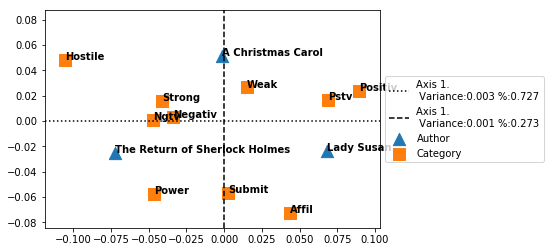

In [19]:
# Set the Author points to be represented by Triangles
plt.scatter(Authors_Score[0], Authors_Score[1], cmap='viridis', s=150, marker = '^', label='Author')

# Set the Category points to be represented by Squares
plt.scatter(Category_Score[0], Category_Score[1], cmap='viridis', s=150, marker = 's', label='Category')

# Set the size of the figure
plt.rcParams["figure.figsize"] = (10,10)

name = ["A", "B", "C"]

# Label each point for Author
for i, txt in enumerate(textName):
    plt.annotate(txt, (Authors_Score[0][i],Authors_Score[1][i]), fontsize = 10, fontweight='bold')

# Label each point for Category
for i, txt in enumerate(categories[:10]):
    plt.annotate(txt, (Category_Score[0][i],Category_Score[1][i]), fontsize = 10, fontweight='bold')

# Draw axis

Axis1_Label= "Axis 1. \n Variance:" + str(format(Variance[0], '.3f')) + " %:" + str(format(Variance_total[0], '.3f'))
Axis2_Label= "Axis 1. \n Variance:" + str(format(Variance[1], '.3f')) + " %:" + str(format(Variance_total[1], '.3f'))
plt.axhline(0, color='black',linestyle=':', label=Axis1_Label)
plt.axvline(0, color='black',linestyle='--', label=Axis2_Label)

# Set Legend
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))    

# Display Graph
plt.show()

## Conclusion 

In this notebook we looked at how to clean and tokenize a corpus for content analysis. Afterwards we showcase how to transform that data into a form for MCA. Finally displaying the results of the MCA. Although this notebook only looks at a single application of MCA or Correspondent analysis, it does demostrate what this type of analysis can do.